# Program Header

In [1]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [2]:
data_root = initialize_data_root("AY")

In [3]:
from sklearn import model_selection, metrics, ensemble, preprocessing, pipeline, impute, model_selection

import seaborn as sn
import matplotlib.pyplot as plt

# Import

In [4]:
raw_data = pd.read_csv(data_root + '02-build/clean/2019q3/2019q3merged.csv')

# Clean

In [5]:
data = raw_data.drop('Unnamed: 0', axis = 'columns')\
    .assign(clean_shares = raw_data[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 'columns'))\
    .drop(['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic'], axis = 'columns')

data['market_cap'] = data['7_after'] * data['clean_shares']
data = data.loc[data['market_cap'] > 0,:]
data['market_cap_deciles'] = pd.qcut(data['market_cap'], q = 10, labels = range(10))

In [6]:
print((pd.DataFrame(data.market_cap.describe())/1000000).round())
print()
print("Figures in millions")

       market_cap
count         0.0
mean       7548.0
std       38861.0
min           0.0
25%         119.0
50%         721.0
75%        3320.0
max     1067083.0

Figures in millions


In [9]:
X = data.loc[:,'AccountsPayableCurrent':'TreasuryStockValue']\
    .replace(0, np.nan)
Y_price_deciles = data['market_cap_deciles']
Y_price_change = data['per']

# Base Model

### Split into training and test sets

In [12]:
X_zeros = X.fillna(0)

In [15]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_zeros,Y_price_deciles, test_size = 0.30)

### Random Forest Classifier

In [16]:
rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', oob_score = True)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
Y_pred = rf.predict(X_test)

### Evaluation

We use three evaluation metrics:
1. Accuracy
2. Absolute mean-squared difference in classification
3. Visual check on confusion matrix

In [46]:
def evaluation_metrics(Y_pred, Y_test):
    # Accuracy
    accuracy = np.round(sum(Y_pred == Y_test)/len(Y_test), 3) * 100
    # Absolute mean error
    abs_mean_error = np.round(np.mean(np.abs(np.subtract(Y_pred, np.array(Y_test)))), 3)
    
    # Heatmap of confusion matrix
    heatmap = sn.heatmap(metrics.confusion_matrix(Y_test, Y_pred), annot=True, linewidths=.5)
    # fix for mpl bug that cuts off top/bottom of seaborn viz using code from quora
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()
    print("Accuracy: %.2f%%" %accuracy)
    print("Absolute Mean Error: %.2f" %abs_mean_error)

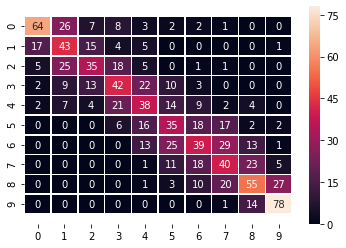

Accuracy: 46.30%
Absolute Mean Error: 0.81


In [19]:
evaluation_metrics(Y_pred, Y_test)

# Hypertuning with Pipeline

In [34]:
steps = [('imputer', impute.SimpleImputer()),
         ('scaler', preprocessing.StandardScaler()),
         ('rf', ensemble.RandomForestClassifier())]

pipeline_rf = pipeline.Pipeline(steps)

parameters_scaler = dict(imputer__strategy = ['mean', 'constant'],
                         imputer__add_indicator = [True, False],
                         rf__n_estimators = [10,100,200,1000],
                         rf__max_depth = [100,1000,10**10])

kfolds = model_selection.KFold(n_splits = 4)

In [35]:
grid_search = model_selection.GridSearchCV(pipeline_rf, 
                                           param_grid = parameters_scaler, 
                                           cv = kfolds, 
                                           scoring = 'accuracy')

In [40]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rf',
                                        RandomForestClassifie

In [41]:
best_1 = grid_search.best_score_
print(best_1)

0.4826418289585097


In [42]:
# Check if best estimator on the bounary of any of the pipeline parameters.
# If yes, extend parameter range.
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=1000,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
      

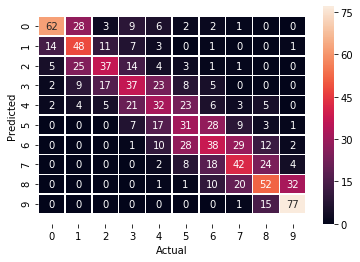

Accuracy: 45.00%
Absolute Mean Error: 0.82


In [47]:
Y_pred = grid_search.predict(X_test)
evaluation_metrics(Y_pred, Y_test)

In fact, our hypertuned parameters have a lower test-accuracy than the baseline random forest, meaning that we're on the wrong end of the bias-variance tradeoff.